## 1 Creating models

In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image 
from keras.optimizers import RMSprop, SGD
import random

num_classes = 1054

In [7]:
def my_preprocessing(x):
    output_size = (160,160)
    w, h, c = x.shape
    th, tw = output_size
    h_diff = h - th
    w_diff = w - tw
    i = random.randint(0, h_diff)
    j = random.randint(0, w_diff)
    #print(i)
    #i = int(round((h - th) / 2.))
    #j = int(round((w - tw) / 2.))
    x_new = x[j:j + tw, i:i + th,:]
    return preprocess_input(x_new)

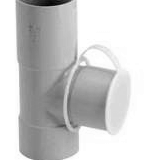

In [139]:
img = image.load_img('/home/pon/kaggle/data/files/train/1000022516/9930854-0.jpg', (180,180))
x = image.img_to_array(img)
#x.shape
x = my_preprocessing(x)
image.array_to_img(x)

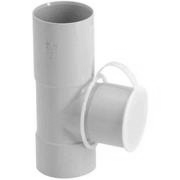

In [141]:
img

### Utils to use other models

In [8]:
def add_new_last_layer(base_model, nb_classes):
    #add new layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x) #new global pooling layer layer
    #x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.3)(x)
    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=predictions)
    return model

### Xception/InceptionResNetV2 model

In [9]:
img_width = 160
img_height = 160

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3)) 
model = add_new_last_layer(base_model, num_classes)
rmsprop = RMSprop(lr=0.02, rho=0.9, epsilon=1e-08, decay=0.9)
#sgd = SGD(lr=0.02, momentum=0.9, nesterov=True)
for layer in base_model.layers:
    layer.trainable = False
#model = make_parallel(model, 2)
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/pon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 79, 79, 32)   96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 79, 79, 32)   0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

batch_normalization_363 (BatchN (None, 3, 3, 288)    864         conv2d_363[0][0]                 
__________________________________________________________________________________________________
batch_normalization_366 (BatchN (None, 3, 3, 320)    960         conv2d_366[0][0]                 
__________________________________________________________________________________________________
activation_361 (Activation)     (None, 3, 3, 384)    0           batch_normalization_361[0][0]    
__________________________________________________________________________________________________
activation_363 (Activation)     (None, 3, 3, 288)    0           batch_normalization_363[0][0]    
__________________________________________________________________________________________________
activation_366 (Activation)     (None, 3, 3, 320)    0           batch_normalization_366[0][0]    
__________________________________________________________________________________________________
max_poolin

In [154]:
#rmsprop = RMSprop(lr=0.02, rho=0.9, epsilon=1e-08, decay=0.9)
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
for layer in base_model.layers:
    layer.trainable = True
#model = make_parallel(model, 2)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

#### Training

In [ ]:
batch_size = 80

img_width = 160
img_height = 160

datagen_train = ImageDataGenerator(
    preprocessing_function=my_preprocessing
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
##TODO: Check that the number of images % number of GPU = 0. Delete some images otherwise

train_generator = datagen_train.flow_from_directory(
        './data/files/train_small_single',
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size)

valid_generator = datagen_test.flow_from_directory(
        './data/files/valid_small_single',
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size)

checkpointer = ModelCheckpoint(monitor='val_loss',
                             filepath= '.models_checkpoints/InceptionResNetV2_transfer_small_single' + '_{epoch:03d}-{val_loss:.5f}.hdf5',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='max')

csv_logger = CSVLogger('training.log')

model.fit_generator(
    train_generator,
    epochs=3,
    steps_per_epoch=263127//batch_size,
    validation_data=valid_generator,
    validation_steps=14064//batch_size,
    max_queue_size = 40,
    workers = 64,
    callbacks = [checkpointer, csv_logger],
    initial_epoch = 2)

Found 263127 images belonging to 1054 classes.
Found 14064 images belonging to 1054 classes.
Epoch 3/3
 118/3289 [>.............................] - ETA: 36:07 - loss: 5.4401 - acc: 0.1385

In [12]:
model.save("/home/pon/kaggle/models/InceptionResNetV2_single_transfer_2_epochs_val_acc_0_299.h5")

In [17]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD
model = load_model("/home/pon/kaggle/models/InceptionResNetV2_single_transfer_2_epochs_val_acc_0_299.h5")
for layer in model.layers:
    layer.trainable = True
#sgd = SGD(lr=0.005, momentum=0.5, nesterov=True)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#model = make_parallel(model, 4)
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 79, 79, 32)   96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 79, 79, 32)   0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

#### Train again - come back to Training part

In [ ]:
model.save("./models/xception_small_single_aug_2.h5")

### Transfer learning

In [1]:
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

def setup_to_transfer_learn(model, base_model):
    #create a new model from a pretrained model
    #don't train layers from a pretrained model
    for layer in base_model.layers:
        layer.trainable = False
    rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])


base_model = Xception(weights='imagenet', include_top=False, input_shape = (80, 80, 3)) 
model = add_new_last_layer(base_model, num_classes)
setup_to_transfer_learn(model, base_model)
model.summary()

Using TensorFlow backend.


NameError: name 'add_new_last_layer' is not defined

In [29]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
        './data/files/train_small_aug',
        target_size=(80, 80),
        batch_size=batch_size)

valid_generator = datagen.flow_from_directory(
        './data/files/valid_small',
        target_size=(80, 80),
        batch_size=batch_size)

checkpointer = ModelCheckpoint(filepath='.models_checkpoints/xception_transfer_aug_small_weights.hdf5', verbose=1, save_best_only=True)

model.fit_generator(
    train_generator,
    epochs=1,
    steps_per_epoch=589679//batch_size,
    validation_data=valid_generator,
    validation_steps=93605//batch_size,
    workers = 32,
    callbacks=[checkpointer])

Found 589679 images belonging to 1054 classes.
Found 93605 images belonging to 1054 classes.
Epoch 1/1
575/575 [==============================] - 1007s - loss: 4.8356 - acc: 0.2061 - val_loss: 4.6366 - val_acc: 0.2454


In [30]:
model.save("./models/xception_transfer_aug_small.h5")

## Tuning

### Parallelizm

In [2]:
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model

import tensorflow as tf

def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                
                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))
            
        new_model = Model(input=model.inputs, output=merged)
        ## to save initial model
        funcType = type(model.save)
        # monkeypatch the save to save just the underlying model
        def new_save(self_,filepath, overwrite=True):
            model.save(filepath, overwrite)
        new_model.save=funcType(new_save, new_model)
        return new_model

### Loading model

In [13]:
from keras.models import load_model
model = load_model("./models/xception_transfer_aug_small.h5")
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_7
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_30
13 block2_pool
14 batch_normalization_25
15 add_73
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_31
23 block3_pool
24 batch_normalization_26
25 add_74
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_32
33 block4_pool
34 batch_normalization_27
35 add_75
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_76
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [14]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop

for layer in model.layers:
   layer.trainable = True

model = make_parallel(model, 2)

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

from keras.optimizers import SGD
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
lambda_7 (Lambda)                (None, 80, 80, 3)     0           input_7[0][0]                    
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 80, 80, 3)     0           input_7[0][0]                    
____________________________________________________________________________________________________
model_7 (Model)                  (None, 1054)          23021126    lambda_7[0][0]                   
                                                                   lambda_8[0][0]          

/home/andrey_ponikar/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/andrey_ponikar/miniconda3/envs/py35/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/andrey_ponikar/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [16]:
batch_size = 512

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

##TODO: Check that the number of images % number of GPU = 0. Delete some images otherwise

train_generator = datagen.flow_from_directory(
        './data/files/train_small_aug',
        target_size=(80, 80),
        batch_size=batch_size)

valid_generator = datagen.flow_from_directory(
        './data/files/valid_small',
        target_size=(80, 80),
        batch_size=batch_size)

checkpointer = ModelCheckpoint(filepath='.models_checkpoints/xception_transfer_tuning_small.hdf5', verbose=1, save_best_only=True)

model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=589678//batch_size,
    validation_data=valid_generator,
    validation_steps=93604//batch_size,
    workers = 32,
    callbacks = [checkpointer])

Found 589678 images belonging to 1054 classes.
Found 93604 images belonging to 1054 classes.
Epoch 1/10
1151/1151 [==============================] - 1722s - loss: 3.1948 - acc: 0.3881 - val_loss: 3.0550 - val_acc: 0.4551
Epoch 2/10
1151/1151 [==============================] - 1638s - loss: 2.1526 - acc: 0.5535 - val_loss: 2.9996 - val_acc: 0.4823
Epoch 3/10
1151/1151 [==============================] - 1628s - loss: 1.4764 - acc: 0.6857 - val_loss: 3.0857 - val_acc: 0.4995
Epoch 4/10
1151/1151 [==============================] - 1651s - loss: 0.9856 - acc: 0.7956 - val_loss: 3.1577 - val_acc: 0.5024
Epoch 5/10
1151/1151 [==============================] - 1640s - loss: 0.6542 - acc: 0.8751 - val_loss: 3.3679 - val_acc: 0.5043
Epoch 6/10
 737/1151 [==================>...........] - ETA: 547s - loss: 0.4413 - acc: 0.9300

KeyboardInterrupt: 

In [17]:
model.save("./models/xception_transfer_tuning_small.h5")